In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *
import numpy as np
from numpy.testing import assert_almost_equal as aae
from functools import reduce
tensor_product = lambda *initial_state: reduce(lambda x, y: np.kron(x, y), initial_state)

from scipy import *
from scipy.linalg import *

from sympy import *
from sympy.physics.quantum import TensorProduct as tp

from qiskit.visualization import *

from typing import *

import matplotlib.pyplot as plt

import time

Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')
Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc', line 3 ('backend: TkAgg')


In [2]:
Vector = Tuple[float, float, float]

def bloch_matrix(rotation_axis: Optional[Vector] = None, distribution = None) -> ndarray:
    '''Generate matrix of rotation along a random axis on the Bloch sphere'''
    
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1 , 0], [0, -1]])
    
    # Generate random rotation vector (if called)
        
    if distribution == 'spherical': # Generate vectors on a spherical surface
        theta, a = np.random.uniform(0, 2*np.pi), np.random.uniform(-1, 1)
        s_a = np.sqrt(1-a**2)
        t_x, t_y, t_z = np.cos(theta) * s_a, np.sin(theta) * s_a, a
        sigma_n = t_x*X + t_y*Y + t_z*Z
        return sigma_n, t_x, t_y, t_z
    elif distribution == 'linear': # Generate vectors sampled in a cubical volume
        rotation_axis = np.random.rand(3)
    elif distribution == 'normal': # Generate vectors sampled from a normal distribution
        rotation_axis = np.random.randn(3)
    
    # Normalize Rotation Vector
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
    
    # Calculate rotation matrix
    t_x, t_y, t_z = rotation_axis
    sigma_n = t_x*X + t_y*Y + t_z*Z
    
    return sigma_n

In [3]:
class ArgumentError(Exception):
    pass

def rotation_matrix(theta: float, 
                    matrix: Optional[ndarray] = None, 
                    axis: Optional[Vector] = None, 
                    ) -> ndarray:
    
    """
    Generate rotation matrix along inputted angle
    
    Parameters:
    ----------
    matrix (ndarray): Matrix of base rotation [Defalut: None]
    axis (tuple): Axis of rotation [Defalut: None]
    theta (float): angle of rotation
    
    Return:
    -------
    Rn (ndarray): Rotation matrix along specified axis and angle
    
    """
    
    if matrix is not None:
        return expm(-1j * matrix * (theta/2) )
    
    elif axis is not None:
        matrix = bloch_matrix(axis)
        return expm(-1j * matrix * (theta/2) )
    else:
        raise ArgumentError('Input a matrix or a tuple')

The matrix $M$ is defined as the normalized weighted sum of the Pauli matrices.

$$A = t_xX + t_yY + t_zZ$$

where $t_x^2 + t_y^2 + t_z^2 = I$

Recall that we have $A^2 = I$, which gives us the matrix exponentiation identity

$$e^{\pm i\gamma A} = \cos(\gamma)I \pm i\sin(\gamma)A$$

Numerical verification suggests that the relationship between the matrix powers of $M$ and rotations around the axis $(t_x, t_y, t_z)$ has the form

$$\begin{align}A^{\gamma} &= e^{\pm i\frac{\pi\gamma}{2}} R_A(\pm \pi\gamma ) \\ &= e^{\pm i\frac{\pi\gamma}{2}} e^{\mp i\frac{\pi}{2}A} \\ &= e^{\pm i\frac{\pi\gamma}{2}}\bigg{[}\cos \bigg{(}\frac{\pi\gamma}{2} \bigg{)}I \mp i\sin\bigg{(}\frac{\pi\gamma}{2} \bigg{)}A \bigg{]}\end{align}$$



We now try to find an expression for the matrix power of $A$ by diagonalization.

$$A = PD P^{-1}$$

where 

$$P = \begin{bmatrix}\frac{- t_{x} + i t_{y}}{t_{z} + 1} & \frac{- t_{x} + i t_{y}}{t_{z} - 1}\\1 & 1\end{bmatrix}, \quad D = \begin{bmatrix}e^{i\pi} & 0\\0 & 1\end{bmatrix}, \quad P^{-1} = \frac{1}{2}\begin{bmatrix}- t_{x} - i t_{y} & t_{z} + 1\\t_{x} + i t_{y} & 1 - t_{z}\end{bmatrix}$$

Now we can take the matrix power by taking the power of the elements in $D$

$$D^{\gamma} = \begin{bmatrix}e^{i\pi\gamma} & 0\\0 & 1\end{bmatrix}$$

And now multiply back with $P$ and $P^{-1}$ gives us

$$\begin{align}A^{\gamma} &= \frac{1}{2}\begin{bmatrix} (1-e^{i\pi\gamma})t_z + (1+ e^{i\pi\gamma}) & (1-e^{i\pi\gamma})(t_x-it_y) \\ (1-e^{i\pi\gamma})(t_x+it_y) & -(1-e^{i\pi\gamma})t_z + (1+e^{i\pi\gamma})\end{bmatrix} \\\\ &= \frac{1+e^{i\pi\gamma}}{2}I + \frac{1-e^{i\pi\gamma}}{2} A
\end{align}$$

Using complex trigononometric identities, we get

$$A^{\gamma} = e^{ i\frac{\pi\gamma}{2}} \bigg{[}\cos \bigg{(}\frac{\pi\gamma}{2} \bigg{)}I - i\sin\bigg{(}\frac{\pi\gamma}{2} \bigg{)}A \bigg{]}$$

Some symbolic calculation steps are done below.

### Symbolic Calculation

In [4]:
tx, ty, tz = symbols('t_x, t_y, t_z')

gamma = symbols('gamma')

ID = Matrix([[1, 0], [0, 1]])
X = Matrix([[0, 1], [1, 0]])
Y = Matrix([[0, -I], [I, 0]])
Z = Matrix([[1, 0], [0, -1]])

A = tx*X + ty*Y + tz*Z

B = cos(gamma*pi / 2) *ID + I*sin(gamma*pi/2)*A
display(B)
B.subs(gamma, 1) * -I

Matrix([
[I*t_z*sin(pi*gamma/2) + cos(pi*gamma/2),          I*(t_x - I*t_y)*sin(pi*gamma/2)],
[        I*(t_x + I*t_y)*sin(pi*gamma/2), -I*t_z*sin(pi*gamma/2) + cos(pi*gamma/2)]])

Matrix([
[        t_z, t_x - I*t_y],
[t_x + I*t_y,        -t_z]])

In [5]:
P, D = A.diagonalize()

In [6]:
P = P.subs(tx**2 + ty**2 + tz**2, 1)

P

Matrix([
[(-t_x + I*t_y)/(t_z + 1), (-t_x + I*t_y)/(t_z - 1)],
[                       1,                        1]])

In [7]:
D.subs(tx**2 + ty**2 + tz**2, 1)

Matrix([
[-1, 0],
[ 0, 1]])

In [8]:
P_inv = P.inv().subs(tx**2 + ty**2 + tz**2, 1)
P_inv = P_inv.subs(2*tx**2 + 2*ty**2 + 2*tz**2, 2)
P_inv = P_inv.subs(tx**2 + ty**2 + 2*tz**2, 1 + tz**2)

P_inv

Matrix([
[-(t_z**2 - 1)/(-2*t_x + 2*I*t_y), t_z/2 + 1/2],
[ (t_z**2 - 1)/(-2*t_x + 2*I*t_y), 1/2 - t_z/2]])

In [9]:
simplify(P_inv)

Matrix([
[(t_z**2 - 1)/(2*(t_x - I*t_y)), t_z/2 + 1/2],
[(1 - t_z**2)/(2*(t_x - I*t_y)), 1/2 - t_z/2]])

In [10]:
B

Matrix([
[I*t_z*sin(pi*gamma/2) + cos(pi*gamma/2),          I*(t_x - I*t_y)*sin(pi*gamma/2)],
[        I*(t_x + I*t_y)*sin(pi*gamma/2), -I*t_z*sin(pi*gamma/2) + cos(pi*gamma/2)]])

In [11]:
P_inv = Matrix([[-(tx+I*ty)/2, (1+tz)/2], [(tx+I*ty)/2, (1-tz)/2]])

P_inv*2

Matrix([
[-t_x - I*t_y, t_z + 1],
[ t_x + I*t_y, 1 - t_z]])

In [12]:
D = Matrix([[exp(I*pi*gamma), 0], [0, 1]])

In [13]:
C = simplify(P@D@P_inv)*2

### Verification

We numerical test the accuracy of our calculation. We generate our rotation axis from a uniform distribution of points on a spherical surface.

In [14]:
def frac_mat_pow(mat, angle):
    '''Calculate fractional matrix power faster than scipy'''
    eig_val, eig_vec = np.linalg.eig(mat)
    
    return eig_vec@np.diag(eig_val**angle)@np.linalg.inv(eig_vec)

### Uniform Spherical Sampling

In [176]:

ID = np.identity(2)

T = 0
x_true, y_true, z_true = [], [], []
x_false, y_false, z_false = [], [], []

for _ in range(10_000):
    A, tx, ty, tz = bloch_matrix(distribution = 'spherical')
    gamma = np.random.rand()*50
    
    if np.all(np.isclose(np.exp(1j*np.pi*gamma/2) * ( np.cos(np.pi*gamma/2)*ID - 1j*np.sin(np.pi*gamma/2)*A), 
                         frac_mat_pow(A, gamma))):
        
        T +=1
        
        x_true.append(tx); y_true.append(ty); z_true.append(tz)
    else:   
        x_false.append(tx); y_false.append(ty); z_false.append(tz)

In [180]:
print(f'Accuracy: {T/ (10_000) * 100}%')

Accuracy: 60.3%


We tested the number of equality between $A^{\gamma}$ and $e^{ i\frac{\pi\gamma}{2}} \bigg{[}\cos \bigg{(}\frac{\pi\gamma}{2} \bigg{)}I - i\sin\bigg{(}\frac{\pi\gamma}{2} \bigg{)}A \bigg{]}$. We find that on average, the accuracy is 60%. The other 40% equality occurs between $A^{\gamma}$ and $e^{-i\frac{\pi\gamma}{2}} \bigg{[}\cos \bigg{(}\frac{\pi\gamma}{2} \bigg{)}I + i\sin\bigg{(}\frac{\pi\gamma}{2} \bigg{)}A \bigg{]}$.

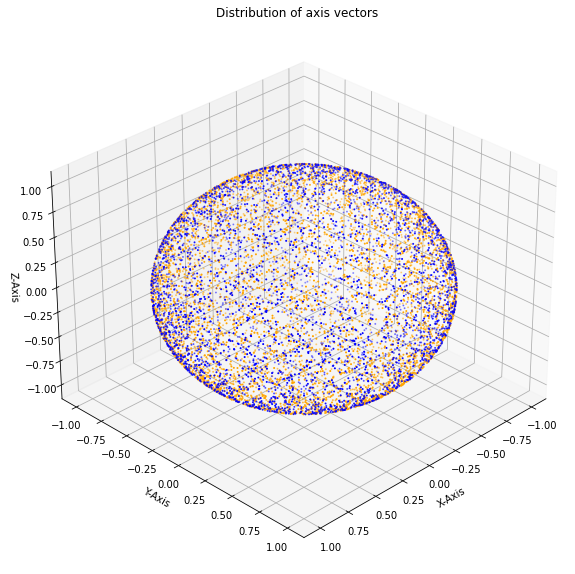

In [178]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 10))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter(x_true, y_true, z_true, c = 'orange', s = 1)
ax.scatter(x_false, y_false, z_false, c = 'blue', s = 1)
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
ax.set_title('Distribution of axis vectors')
ax.view_init(elev = 30, azim = 45)
plt.show()

### Interval Sampling

In [239]:
ID = np.identity(2)

T = 0

x_true, y_true, z_true = [], [], []
x_false, y_false, z_false = [], [], []

no_theta = 50
no_a = 50

for theta in np.linspace(0, 2*np.pi, no_theta):
    for a in np.linspace(-1, 1, no_a):
        s_a = np.sqrt(1-a**2)
        t_x, t_y, t_z = np.cos(theta) * s_a, np.sin(theta) * s_a, a
        sigma_n = t_x*X + t_y*Y + t_z*Z
        gamma = 10

        if np.all(np.isclose(np.exp(1j*np.pi*gamma/2) * ( np.cos(np.pi*gamma/2)*ID - 1j*np.sin(np.pi*gamma/2)*A), 
                             frac_mat_pow(A, gamma))):

            T+=1; x_true.append(t_x); y_true.append(t_y); z_true.append(t_z)
        else:   
            x_false.append(t_x); y_false.append(t_y); z_false.append(t_z)

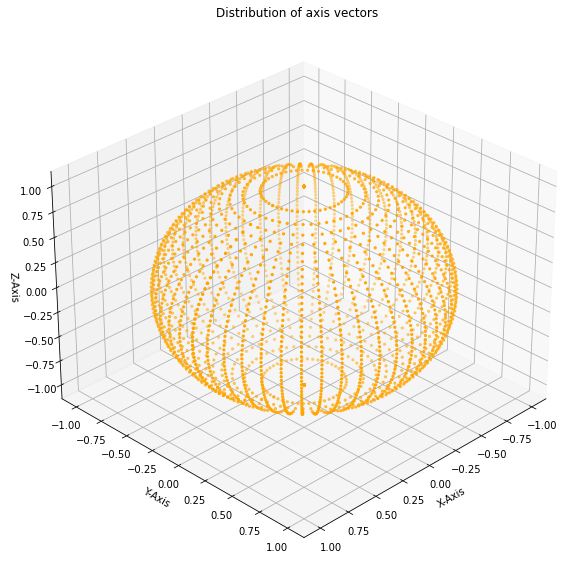

In [240]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 10))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter(x_true, y_true, z_true, c = 'orange', s = 5)
ax.scatter(x_false, y_false, z_false, c = 'blue', s = 1)
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
ax.set_title('Distribution of axis vectors')
ax.view_init(elev = 30, azim = 45)
plt.show()

Now everything looks like it follows one equation?!